In [2]:
import numpy as np
import math
import statistics as stat
import random
import pandas as pd

from scipy.optimize import isotonic_regression

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


lblue = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred = (0.69411765, 0.01568627, 0.05490196)

In [14]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

In [3]:
data = pd.read_csv('COVID19MEXICO.csv')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(1304796, 40)
['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB', 'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL', 'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI']


In [4]:
comorbidities = ['HIPERTENSION', 'ASMA', 'DIABETES', 'CARDIOVASCULAR', 'OBESIDAD']
outcomes = ['CLASIFICACION_FINAL', 'RESULTADO_LAB', 'RESULTADO_ANTIGENO', 'UCI']


X = np.array(data["CLASIFICACION_FINAL"])
Y = np.array(data["HIPERTENSION"])
Z = np.array(data["EDAD"])

for nm in comorbidities:
    Y = np.array(data[nm])
    # print(np.unique(Y), data[nm].value_counts())

for nm in outcomes:
    X = np.array(data[nm])
    print(np.unique(X), data[nm].value_counts())


[1 2 3 4 5 6 7] CLASIFICACION_FINAL
7    754312
3    426948
6    110634
1      7934
5      4705
4       237
2        26
Name: count, dtype: int64
[ 1  2  3  4 97] RESULTADO_LAB
97    1002316
2      232649
1       51722
4       17431
3         678
Name: count, dtype: int64
[ 1  2 97] RESULTADO_ANTIGENO
2     622045
1     390577
97    292174
Name: count, dtype: int64
[ 1  2 97 99] UCI
97    1161656
2      137757
1        5121
99        262
Name: count, dtype: int64


In [5]:
df = data[data['HIPERTENSION'] != 98]
df = df[df['RESULTADO_ANTIGENO'] != 97]
df = df[df['EDAD'] >= 20]

X = 2-np.array(df["RESULTADO_ANTIGENO"])
Y = 2-np.array(df["HIPERTENSION"])
Z = np.array(df["EDAD"])

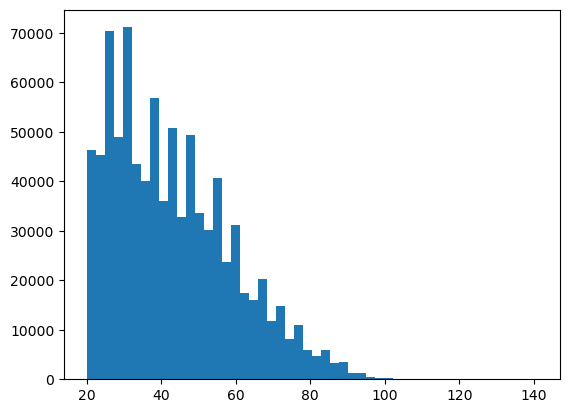

In [6]:
plt.hist(Z, bins=50)
plt.show()

In [7]:
len(Z)

877213

In [9]:
# n = len(Z)
# K = n//15
# M_cb = cross_bin_matching(Y, Z, K)


In [8]:
df['HYPERTENSION'] = 2-df['HIPERTENSION']
df['RESULT'] = 2-df['RESULTADO_ANTIGENO']

<Axes: xlabel='EDAD', ylabel='RESULT'>

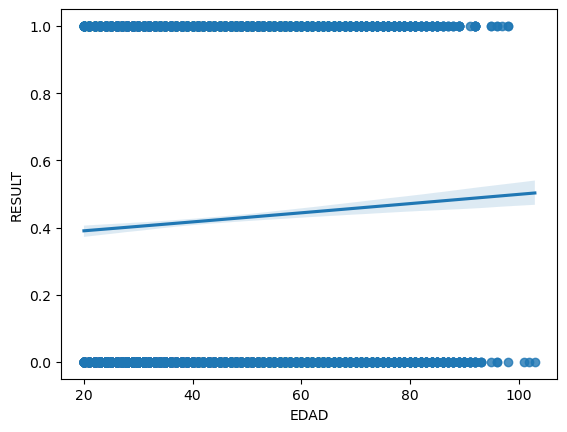

In [10]:
import seaborn as sns
sns.regplot(x="EDAD", y="RESULT", data=df.iloc[np.random.choice(len(Z), 10000, replace=False)], logistic=True)

<Axes: xlabel='EDAD', ylabel='HYPERTENSION'>

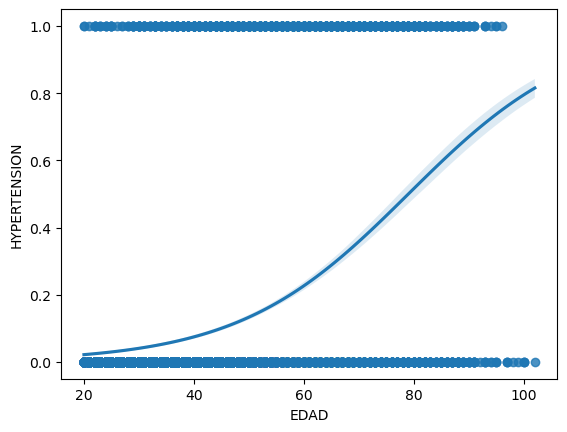

In [11]:
sns.regplot(x="EDAD", y="HYPERTENSION", data=df.iloc[np.random.choice(len(Z), 10000, replace=False)], logistic=True)

In [121]:
# df["HYPERTENSION"] + df["HIPERTENSION"]

In [12]:
n = len(Z)
M_nbhd = immediate_neighbor_matching(Y, Z)
2*len(M_nbhd), n

(792834, 877213)

In [15]:
SCINT_test(X, Y, M_nbhd)

0.001996007984031936

In [16]:
len(immediate_neighbor_matching(Y, Z)), len(immediate_neighbor_matching(-Y, Z))

(396417, 396307)

# Generate fake $X$

In [17]:
o = np.argsort(Z)


In [18]:
prob = isotonic_regression(X[o]).x
Xtilde_sorted = (np.random.rand(n) <= prob)*1
Xtilde = Xtilde_sorted[o.argsort()]

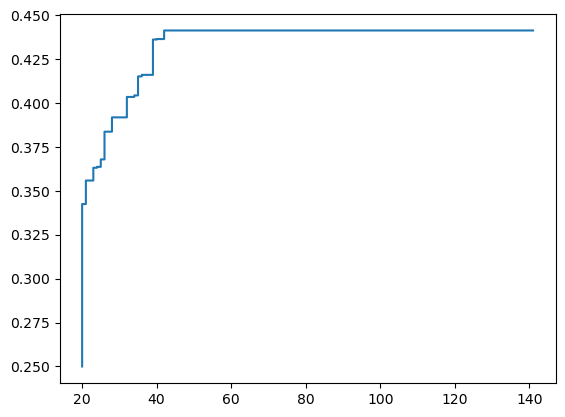

In [19]:
plt.plot(Z[o],prob)
plt.show()

In [20]:
SCINT_test(Xtilde, Y, M_nbhd)

0.37524950099800397